In [61]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [62]:
class CustomLinear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(CustomLinear, self).__init__()
        # Use the nn.Linear layer internally
        self.linear = nn.Linear(input_features, output_features, bias)
        
    @property
    def weight(self):
        return self.linear.weight

    def forward(self, input):
        # Forward pass through the internal nn.Linear layer
        return self.linear(input)
    
    def neural_balance(self, previous_layer, return_lambdas = False, order = 2, random = False, random_perc = 0.1):
        shape = previous_layer.weight.shape[0]
        lambdas = []#torch.tensor([])
        
        if random:
            random_index_num = int(random*shape)
            random_indexes = np.random.choice(shape, random_index_num, replace=False)
            random_indexes_tensor = torch.from_numpy(random_indexes).long().to(previous_layer.weight.device)
            
            incoming = torch.linalg.norm(previous_layer.weight[random_indexes_tensor], dim=1, ord=order)
            outgoing = torch.linalg.norm(self.linear.weight[:, random_indexes_tensor], dim=0, ord=order)
            optimal_l = torch.sqrt(outgoing/incoming)
            previous_layer.weight[random_indexes_tensor].data *= optimal_l.unsqueeze(1)
            self.linear.weight[:,random_indexes_tensor].data /= optimal_l

        else:
            incoming = torch.linalg.norm(previous_layer.weight, dim=1, ord=order)
            outgoing = torch.linalg.norm(self.linear.weight, dim=0, ord=order)
            optimal_l = torch.sqrt(outgoing/incoming)
#             print(incoming/outgoing)
            previous_layer.weight.data *= optimal_l.unsqueeze(1)
            self.linear.weight.data /= optimal_l
            
        if return_lambdas:
            lambdas.append(optimal_l)
#         else: return torch.tensor([])
        return lambdas


In [63]:
# Toy data generation
def generate_toy_data(num_samples=1000, dims=2):
    # Generate random points
    x = np.random.randn(num_samples, dims).astype(np.float32)
    # Labels: 1 if the point is outside the circle of radius sqrt(2), 0 otherwise
    y = (np.sum(np.square(x), axis=1) > 2).astype(np.float32)
    return torch.tensor(x), torch.tensor(y).unsqueeze(-1)

x, y = generate_toy_data()

# Define a two-layer network
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet, self).__init__()
        
        self.layers = nn.Sequential(
          CustomLinear(input_size, hidden_size),
          nn.ReLU(),
          CustomLinear(hidden_size, hidden_size+1),
          nn.ReLU(),
          CustomLinear(hidden_size+1, output_size),
          nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

# Network parameters
input_size = 2 # As we generated 2 dimensional toy data
hidden_size = 4 # Example: 4 hidden units, customizable
output_size = 1 # Binary classification

model = TwoLayerNet(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [64]:
# Training
num_epochs = 1000
accuracies= []
lambdas = []
linear_layers = []
order = 2

for layer in model.layers:
    if(isinstance(layer, CustomLinear)):
        linear_layers.append(layer)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%1==0:
        for i in range(2):
            for count, linear in enumerate(linear_layers):
                if count==0: #or count == len(linear_layers)-1:
                    continue

                lambda_ = linear.neural_balance(linear_layers[count-1], order = order, random = False, return_lambdas=True)
                lambdas.append(lambda_)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.6783
Epoch [20/1000], Loss: 0.6508
Epoch [30/1000], Loss: 0.6145
Epoch [40/1000], Loss: 0.5770
Epoch [50/1000], Loss: 0.5412
Epoch [60/1000], Loss: 0.5090
Epoch [70/1000], Loss: 0.4776
Epoch [80/1000], Loss: 0.4449
Epoch [90/1000], Loss: 0.4088
Epoch [100/1000], Loss: 0.3643
Epoch [110/1000], Loss: 0.3219
Epoch [120/1000], Loss: 0.2884
Epoch [130/1000], Loss: 0.2587
Epoch [140/1000], Loss: 0.2378
Epoch [150/1000], Loss: 0.2195
Epoch [160/1000], Loss: 0.2026
Epoch [170/1000], Loss: 0.1878
Epoch [180/1000], Loss: 0.1744
Epoch [190/1000], Loss: 0.1613
Epoch [200/1000], Loss: 0.1506
Epoch [210/1000], Loss: 0.1417
Epoch [220/1000], Loss: 0.1336
Epoch [230/1000], Loss: 0.1268
Epoch [240/1000], Loss: 0.1209
Epoch [250/1000], Loss: 0.1155
Epoch [260/1000], Loss: 0.1106
Epoch [270/1000], Loss: 0.1061
Epoch [280/1000], Loss: 0.1020
Epoch [290/1000], Loss: 0.0981
Epoch [300/1000], Loss: 0.0946
Epoch [310/1000], Loss: 0.0912
Epoch [320/1000], Loss: 0.0881
Epoch [330/1000],

In [65]:
weight_list = []
for layer in model.layers:
    if(isinstance(layer, CustomLinear)):
#         linear_layers.append(layer)
        weight_list.append(layer.weight)

l2_balanced = [item for tensor in weight_list for sublist in tensor.tolist() for item in sublist]

# np.save("toy_weights_neural_balance.npy", l2_balanced)
np.save("toy_weights.npy", l2_balanced)

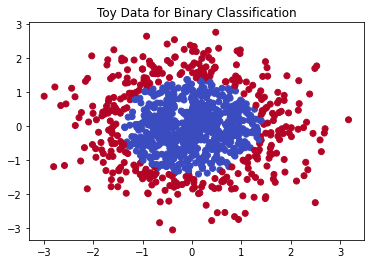

In [66]:
# Optionally, visualize the data
plt.scatter(x[:, 0], x[:, 1], c=y[:, 0], cmap="coolwarm")
plt.title("Toy Data for Binary Classification")
plt.show()

In [67]:
import random

def generate_random_numbers(count, length):
    """
    Generate a list of random numbers between 0 (inclusive) and 256 (exclusive).

    Parameters:
    count (int): The number of random numbers to generate.

    Returns:
    list: A list containing 'count' random numbers.
    """
    # Generate 'count' random numbers and return them in a list
    return [random.randint(0, length) for _ in range(count)]


In [68]:
layer = 5
tmp = [[] for i in range(layer)]

# random_numbers = generate_random_numbers(number_of_randoms, layer)
numbers = list(range(layer))

for j in range(len(numbers)):
    for i in range(200):
        if len(lambdas[i][0])==layer:
            tmp[j].append(lambdas[i][0][numbers[j]].item())
print(tmp)

[[0.8401056528091431, 0.9165921807289124, 0.9733275175094604, 0.9931738972663879, 0.9967160224914551, 0.999254047870636, 0.9981179237365723, 0.9995448589324951, 0.9983025789260864, 0.9995530247688293, 0.998500645160675, 0.999578595161438, 0.9986785650253296, 0.9996001720428467, 0.9987804293632507, 0.9996172785758972, 0.9987800121307373, 0.9996342062950134, 0.9987297058105469, 0.9996539354324341, 0.9986265897750854, 0.9996723532676697, 0.9984787702560425, 0.99969482421875, 0.9983105659484863, 0.9997152090072632, 0.998138964176178, 0.999742329120636, 0.997986912727356, 0.9997684955596924, 0.997840166091919, 0.9997869729995728, 0.9977158904075623, 0.9997900724411011, 0.997631311416626, 0.9997664093971252, 0.9975731372833252, 0.9997277855873108, 0.9975299835205078, 0.9996846914291382, 0.9975160956382751, 0.9996408224105835, 0.9975320100784302, 0.9995853304862976, 0.9975724220275879, 0.9995286464691162, 0.9976412057876587, 0.9994727373123169, 0.9977364540100098, 0.9994169473648071, 0.997848

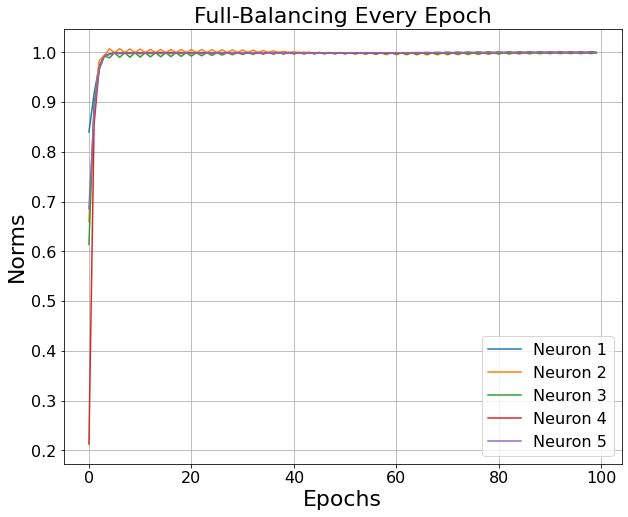

In [69]:

import matplotlib.pyplot as plt

# Let's assume these are the accuracy values of your model over epochs
epochs_norm = list(range(100))

plt.figure(figsize=(10, 8))

# Create a simple line plot
for i in range(layer):
    plt.plot(epochs_norm, tmp[i], linestyle='-', label=f'Neuron {i+1}')

# Add labels and title
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Norms', fontsize=22)
plt.title('Full-Balancing Every Epoch', fontsize=22)
# plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Optionally, add a grid
plt.grid(True)

plt.legend(fontsize=16)

# Show the plot
plt.savefig('toyFullBalanceEveryEpoch.pdf', dpi=1000)

## Plot weights

In [70]:
toy_weights_neural_balance = np.load('toy_weights_neural_balance.npy')
toy_weights = np.load('toy_weights.npy')

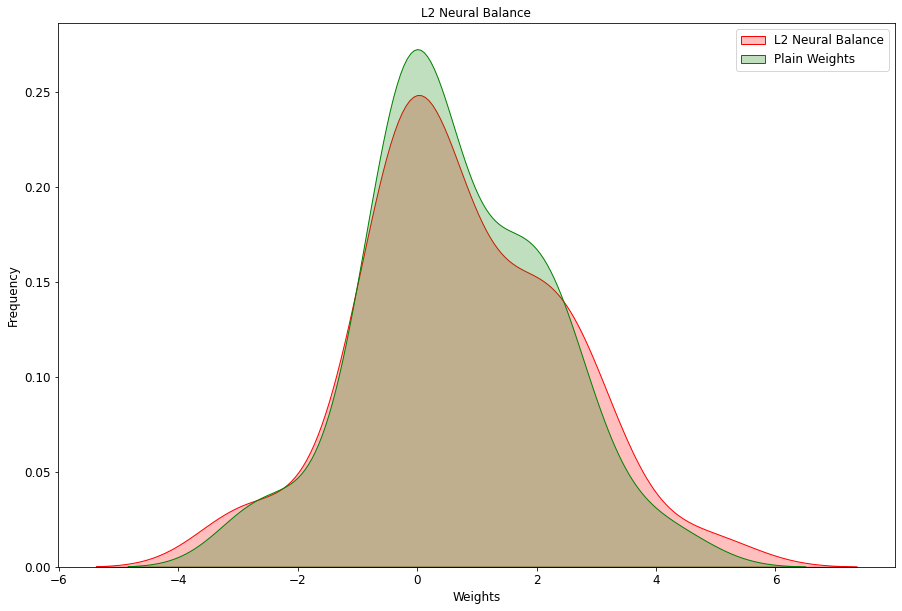

In [71]:
plt.figure(figsize=(15,10))
plt.title('L2 Neural Balance', fontsize='large')
# sns.kdeplot(l1_regularized, color='blue', fill=True, label = 'L1 Regularization')
sns.kdeplot(toy_weights_neural_balance, color='red', fill=True, label = 'L2 Neural Balance')
sns.kdeplot(toy_weights, color='green', fill=True, label = 'Plain Weights')
plt.legend(fontsize='large')
plt.xlabel('Weights', fontsize='large')
plt.ylabel('Frequency', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

# plt.xlim(-.2, 0.2)
# plt.ylim(0,10)

plt.show()

In [72]:
5 layer rnn, 2 layer rnn

lcn cifar

SyntaxError: invalid syntax (3464288050.py, line 1)